# Speech Sample Analysis

This notebook goes through a simple analysis of a single speech sample

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from speechbrain.processing.voice_analysis import *

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


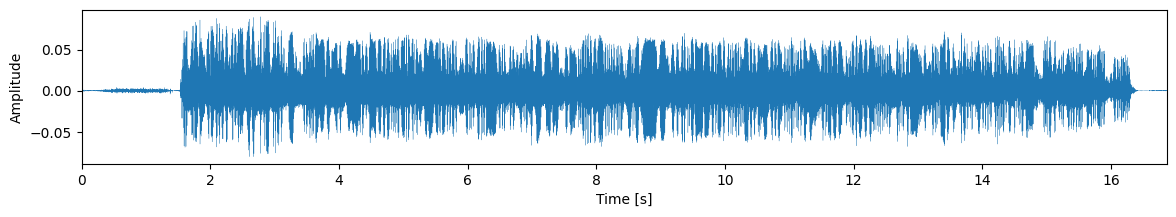

In [2]:
# Load sustained phonation recording from QPN dataset
audio_filename = "qpn_PD00020_a1.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Parameters for all figures in the document
plt.rcParams["figure.figsize"] = (14,2)
plt.rcParams['axes.xmargin'] = 0

# Downsample to reduce number of points on the plot
downsample_factor = 10
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.2)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Intro

To understand how this speech analysis works, we'll step through the `vocal_characteristics` function. The very fist lines
just set up the variables needed for computation

In [3]:
# Frequency of human speech is usually between 75-300 Hz
min_f0_Hz = 75
max_f0_Hz = 300

# A new window of 0.04 second length every 0.01 seconds
step_size = 0.01
window_size = 0.04

# Do some number manipulations
step_samples = int(step_size * sample_rate)
window_samples = int(window_size * sample_rate)
max_lag = int(sample_rate / min_f0_Hz)
min_lag = int(sample_rate / max_f0_Hz)

print("Samples between (the start of) one frame and the next:", step_samples)
print("Samples contained within each frame:", window_samples)
print("Number of samples in the maximum lag:", max_lag)
print("Number of samples in the minimum lag:", min_lag)

Samples between (the start of) one frame and the next: 160
Samples contained within each frame: 640
Number of samples in the maximum lag: 213
Number of samples in the minimum lag: 53


Our sanity check for these values is that at least one complete period will be contained in the frame (for minimum Hz) and at most 8 for maximum Hz.

## Getting voiced portion

In order to do a f0 analysis, we have to figure out which portions are harmonic. We use both autocorrelation and jitter (as in PRAAT).

Autocorrelation is the cross-correlation of a signal with itself at various lags.
For harmonic signals, there are peaks at regular intervals corresponding to the period.
The autocorrelation ratio is the ratio of the strongest peak against the theoretical maximum
which occurs when the lag is zero.

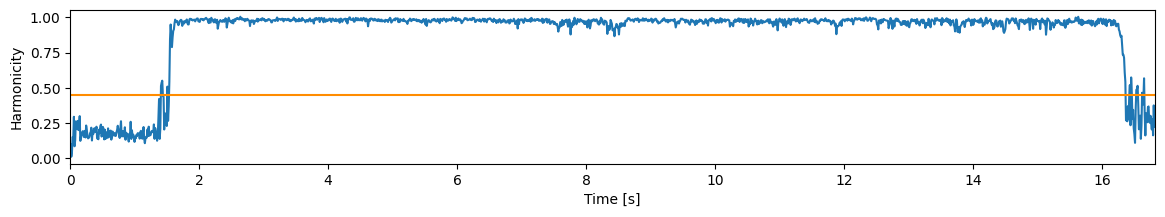

In [4]:
# Split into frames, and compute autocorrelation for each frame
frames = audio.unfold(-1, window_samples, step_samples)
autocorrelation = autocorrelate(frames)

# Use autocorrelation to estimate harmonicity and best lags
harmonicity, best_lags = autocorrelation[:, :, min_lag:max_lag].max(dim=-1)
best_lags += min_lag
harmonicity_threshold = 0.45

xs = torch.arange(len(harmonicity[0])) * step_size
plt.plot(xs, harmonicity[0])
plt.xlabel("Time [s]")
plt.ylabel("Harmonicity")
plt.axhline(y = harmonicity_threshold, color="darkorange")
plt.show()

In addition, PRAAT marks all frames as unvoiced that exceed a certain jitter threshold, by default 2 percent. We'll estimate jitter using our initial data.

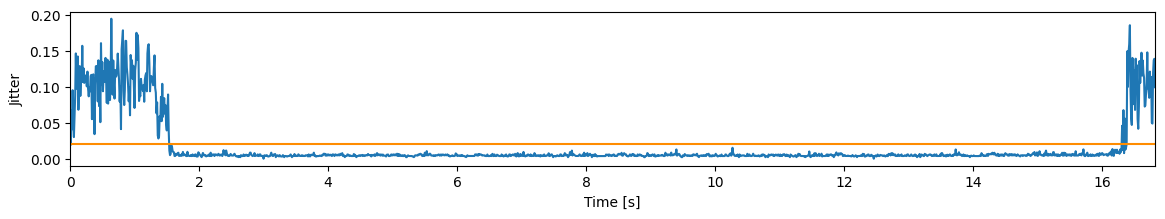

In [5]:
# Compute period-based features, dividing frames based on median best lag
jitter, shimmer = compute_periodic_features(frames, best_lags)
jitter_threshold = 0.02

#plt.plot(xs, harmonicity[0], color="lightblue")
plt.plot(xs, jitter[0])
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.axhline(y = jitter_threshold, color="darkorange")
plt.show()

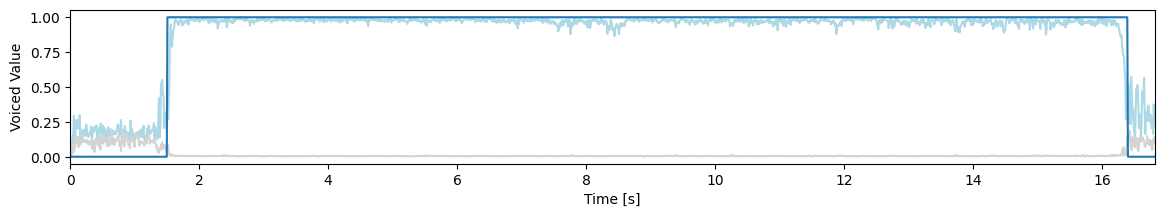

In [6]:
# voicing threshold is simply the intersection of these thresholds
voiced = harmonicity > harmonicity_threshold
voiced &= jitter < jitter_threshold
voiced = neighbor_op(voiced.float(), neighbors=7).bool()

plt.plot(xs, harmonicity[0], color="lightblue")
plt.plot(xs, jitter[0], color="lightgrey")
plt.plot(xs, voiced[0])
plt.xlabel("Time [s]")
plt.ylabel("Voiced Value")
plt.show()

In [7]:
print("Total frame count:", len(voiced[0]))
print("Voiced frame count:", voiced[0].sum().numpy())

Total frame count: 1683
Voiced frame count: 1489


## Computing f0

The fundamental frequency, f0, is the period of the waveform. This is computed by taking the
k-best lags from the autocorrelation and comparing to neighboring frames to avoid octave errors.

Estimated average frequency: 122.7 Hz


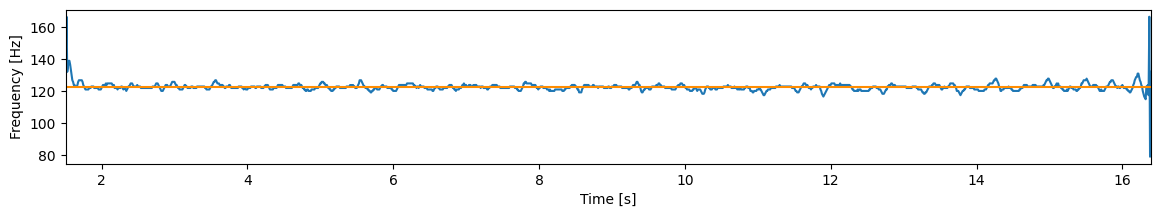

In [8]:
# Convert to hZ
estimated_f0 = sample_rate / best_lags

plt.plot(xs[voiced[0]], estimated_f0[voiced])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.axhline(y = estimated_f0[voiced].mean(), color="darkorange")
print("Estimated average frequency: {0:.1f} Hz".format(estimated_f0[voiced].mean().numpy()))

## Computing vocal characteristics

Common vocal characteristics are jitter, shimmer, and harmonic-to-noise ratio

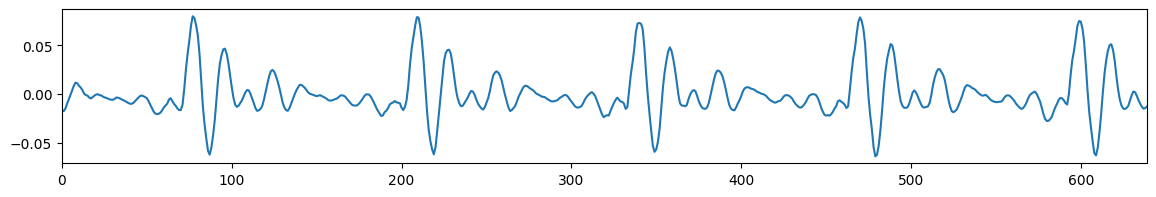

In [9]:
plt.plot(frames[0, 200])
plt.show()

In [10]:
# Compute likely peaks using topk
topk = frames.topk(dim=-1, k=7)
topk.indices[0, 200]

tensor([ 77, 209, 470, 210,  78, 471, 599])

In [11]:
# Jitter = average variation in period length, measured as lag
lags = topk.indices.remainder(best_lags.unsqueeze(-1))
# Compute lags as remainder, use min to avoid wraparound errors
lags = torch.min(lags, best_lags.unsqueeze(-1) - lags)
lags[0, 200]

tensor([54, 53, 54, 52, 53, 53, 56])

In [12]:
# Compute mean difference from mean lag, normalized by period
jitter_frames = (lags - lags.float().mean(dim=-1, keepdims=True)).abs()
jitter = jitter_frames.mean(dim=-1) / best_lags
jitter[0, 200]

tensor(0.0072)

Average Jitter: 0.52%


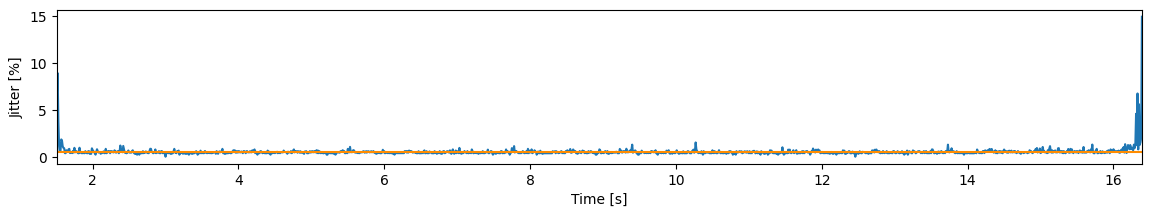

In [13]:
plt.plot(xs[voiced[0]], jitter[voiced] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Jitter [%]")
plt.axhline(y = jitter[voiced].mean() * 100, color="darkorange")
print("Average Jitter: {0:.2f}%".format(100 * jitter[voiced].mean().numpy()))

In [14]:
# Shimmer = average variation in amplitude, normalized by avg amplitude
avg_amps = topk.values.mean(dim=-1, keepdims=True)
amp_diff = (topk.values - avg_amps).abs()
shimmer = amp_diff.mean(dim=-1) / avg_amps.squeeze(-1)
shimmer[0, 200]

tensor(0.0200)

Average Shimmer: 1.89%


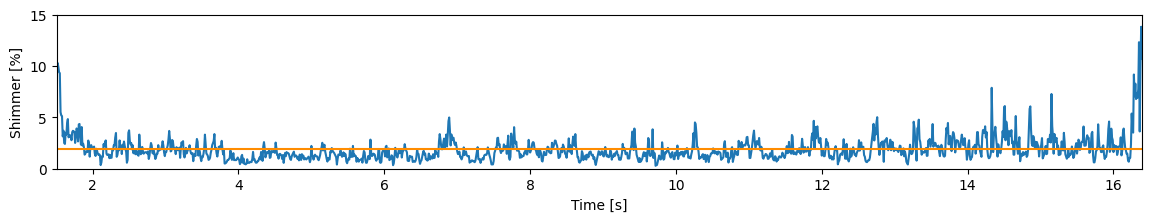

In [15]:
plt.plot(xs[voiced[0]], shimmer[voiced] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Shimmer [%]")
plt.ylim((0, 15))
plt.axhline(y = shimmer[voiced].mean() * 100, color="darkorange")
print("Average Shimmer: {0:.2f}%".format(100 * shimmer[voiced].mean().numpy()))

Average HNR: 16.02


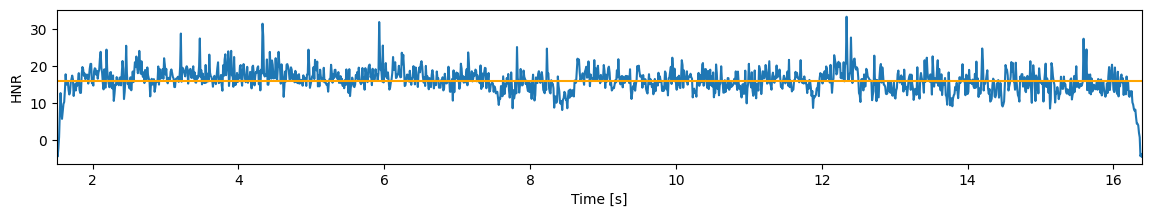

In [16]:
# Autocorrelation is the measure of harmonicity here, 1-harmonicity is noise
# See "Harmonic to Noise Ratio Measurement - Selection of Window and Length"
# By J. Fernandez, F. Teixeira, V. Guedes, A. Junior, and J. P. Teixeira
hnr = 10 * torch.log10(harmonicity / torch.abs(1 - harmonicity))

plt.plot(xs[voiced[0]], hnr[voiced])
plt.xlabel("Time [s]")
plt.ylabel("HNR")
plt.axhline(y = hnr[voiced].mean(), color="orange")
print("Average HNR: {0:.2f}".format(hnr[voiced].mean().numpy()))

In [17]:
# Of course this can all be done in one step
f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio, sample_rate=sample_rate)

## Compute GNE step-by-step

The algorithm is best described in "The Effectiveness of the Glottal to Noise Excitation Ratio for the Screening of Voice Disorders" by Godino-Llorente et al.


In [18]:
# Step 1. Downsample to 10 kHz since voice energy is low above 5 kHz
new_sample_rate = 10000
downsampled_audio = torchaudio.functional.resample(audio, 16000, new_sample_rate)

tensor([ 1.0000, -0.3076, -0.3972, -0.2296, -0.0740, -0.1899,  0.2329,  0.0059,
        -0.0984,  0.0646, -0.0095, -0.0585,  0.1089,  0.0544])


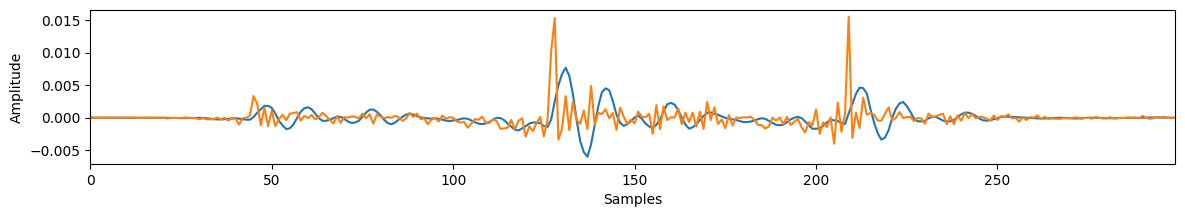

In [19]:
# Step 2. Inverse filter with 30-msec window, 10-msec hop and 13th order LPC
frame_size, hop_size, lpc_order = 300, 100, 13

# Solve for LPC coefficients
window = torch.hann_window(frame_size).view(1, 1, -1)
frames = downsampled_audio.view(1, -1).unfold(-1, frame_size, hop_size) * window

autocorrelation = compute_cross_correlation(frames, frames, width=lpc_order)

# Collapse frame and batch into same dimension, for lfiltering
batch, frame_count, _ = autocorrelation.shape
autocorrelation = autocorrelation.view(batch * frame_count, -1)

# Construct Toeplitz matrices (one per frame)
# This is [[p0, p1, p2...], [p1, p0, p1...], [p2, p1, p0...] ...]
# Our sliding window should go from the end to the front, so flip
# The autocorrelation has an extra value on each end for our prediction values
R = autocorrelation[:, 1: -1].unfold(-1, lpc_order, 1).flip(dims=(1,))
r = autocorrelation[:, lpc_order + 1:]

# Solve for LPC coefficients, generate inverse filter with coeffs 1, -a_1, ...
lpc = torch.linalg.solve(R, r)
a_coeffs = torch.cat((torch.ones(lpc.size(0), 1), -lpc), dim=1)
b_coeffs = torch.zeros_like(a_coeffs)
b_coeffs[:, 0] = 1

# Perform filtering
excitation = torchaudio.functional.lfilter(frames, b_coeffs, a_coeffs, clamp=False)
plt.plot(frames[0, 200, :] * 0.1)
plt.plot(excitation[0, 200, :])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Print the coefficients so we can check them
print(a_coeffs[0])

In [20]:
# Just prove that we correctly calculated the coefficients
import librosa

librosa.lpc(frames[0, 0].numpy(), order=13)

array([ 1.        , -0.30757397, -0.397176  , -0.22955747, -0.07402234,
       -0.18987924,  0.2328875 ,  0.00587844, -0.09842138,  0.06459121,
       -0.00947815, -0.0585319 ,  0.10887896,  0.05438369], dtype=float32)

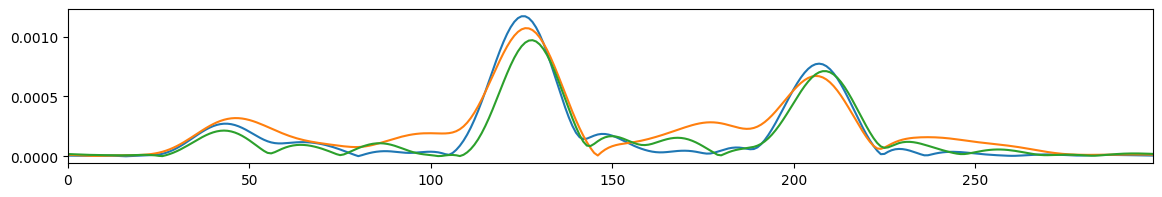

In [21]:
# Step 3. Compute Hilbert envelopes for each frequency bin
bandwidth = 1000
fshift = 300
min_freq, max_freq = bandwidth // 2, new_sample_rate // 2 - bandwidth // 2
center_freqs = range(min_freq, max_freq, fshift)
envelopes = {
    center_freq: compute_hilbert_envelopes(
        excitation, center_freq, bandwidth, new_sample_rate
    )
    for center_freq in center_freqs
}
plt.plot(envelopes[500][0, 200])
plt.plot(envelopes[1100][0, 200])
plt.plot(envelopes[1400][0, 200])

In [22]:
# Step 4. Compute cross correlation between (non-neighboring) frequency bins
correlations = [
    compute_cross_correlation(envelopes[freq_i], envelopes[freq_j], width=3)
    for freq_i in center_freqs
    for freq_j in center_freqs
    if (freq_j - freq_i) > bandwidth // 2
]

# Step 5. The maximum cross-correlation is the GNE score
gne = torch.stack(correlations, dim=-1).amax(dim=(2, 3))
gne = -10 * torch.log10(1 - gne)

tensor(21.9163)


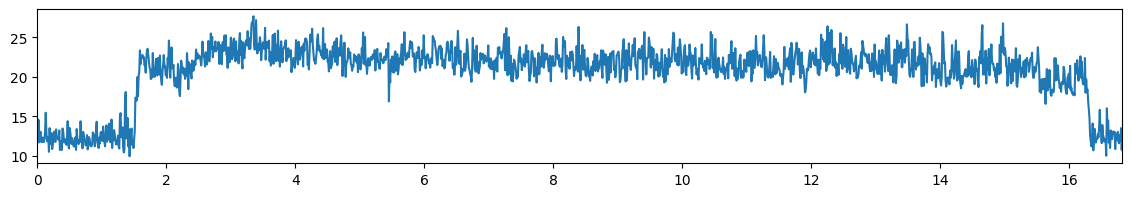

In [23]:
plt.plot(xs, gne[0, :-1])
print(gne[0, :-1][voiced[0]].mean())

## PRAAT-Parselmouth

We'll run a similar analysis to verify that our numbers look accurate.

In [25]:
import parselmouth
from parselmouth.praat import call
import numpy as np

# Bundle these to compute them again later
def compute_praat_features(audio_filename):
    f0min = 75
    f0max = 300
    
    sound = parselmouth.Sound(audio_filename)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan

    jitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    harmonicity = sound.to_harmonicity()

    return pitch.xs(), pitch_values, jitter, shimmer, harmonicity


pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(audio_filename)

Estimated average frequency (SpeechBrain): 126.8 Hz
Estimated average frequency (PRAAT): 122.7 Hz


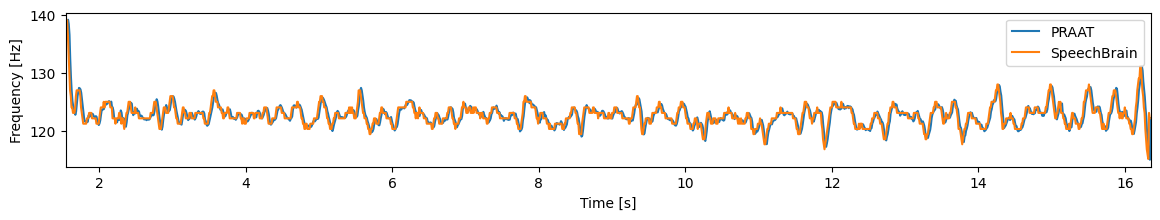

In [26]:
# Pitch comparison
plt.plot(pitch_xs, pitch_values)
plt.plot(xs[voiced[0]], estimated_f0[voiced])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])

print("Estimated average frequency (SpeechBrain): {0:.1f} Hz".format(estimated_f0.mean().numpy()))
print("Estimated average frequency (PRAAT): {0:.1f} Hz".format(np.nanmean(pitch_values)))

In [27]:
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 0.50%
Average Jitter (PRAAT): 0.46%


In [28]:
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 1.85%
Average Shimmer (PRAAT): 2.74%


Average HNR (SpeechBrain): 16.2%
Average HNR (PRAAT): 19.3%


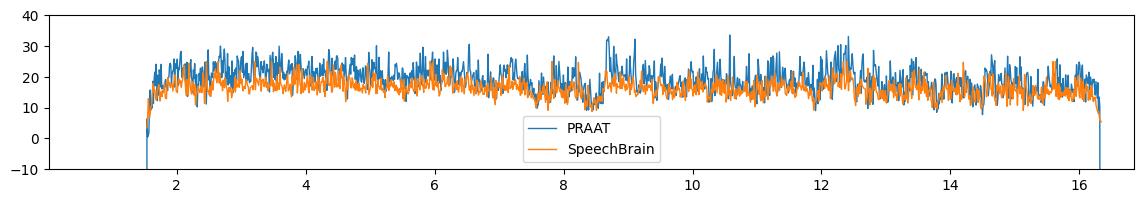

In [29]:
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T, linewidth=1)
plt.plot(xs[voiced[0]], hnr[voiced], linewidth=1)
plt.ylim((-10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[voiced].mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

## Difficult Example

To further verify that we are able to closely match the PRAAT vocal characteristics, we compute the same statistics for a more difficult example. The "voiced" and pitch computation is very difficult, even ambiguous, in this example due to numerous voice breaks. However, we want to at least show similar jitter, shimmer, and hnr values.

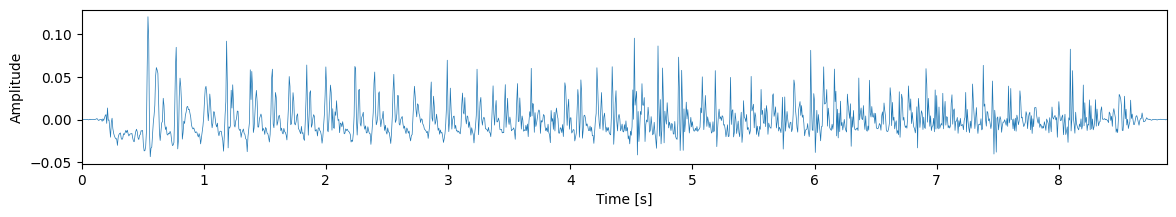

In [30]:
audio_filename = "qpn_MNI0144_a1.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Downsample to reduce number of points on the plot
downsample_factor = 100
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

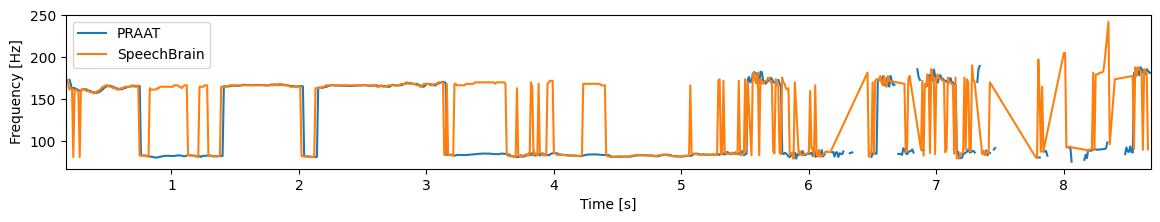

In [31]:
estimated_f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio, sample_rate=sample_rate)
pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(audio_filename)

xs = torch.arange(len(voiced[0])) * step_size
plt.plot(pitch_xs, pitch_values)
plt.plot(xs[voiced[0]], estimated_f0[voiced])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])
plt.show()

In [32]:
# Jitter is not too far off
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 1.54%
Average Jitter (PRAAT): 1.56%


In [33]:
# Shimmer is little further but still fairly close
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 4.08%
Average Shimmer (PRAAT): 7.03%


Average HNR (SpeechBrain): 11.6%
Average HNR (PRAAT): 15.1%


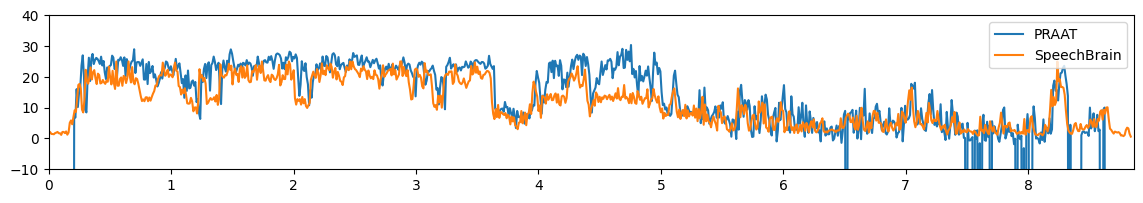

In [34]:
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T)
plt.plot(xs, hnr[0])
plt.ylim((-10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr.mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

tensor(17.4968)


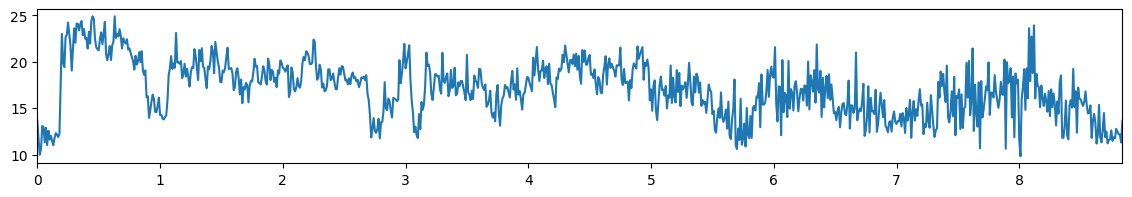

In [36]:
gne = compute_gne(audio)
plt.plot(xs, gne[0, :-1])
print(gne[:, :-1][voiced].mean())

## Stats over QPN dataset

We show the stats are similar when computed over the full dataset too.

In [37]:
from getpass import getpass

data_folder = getpass("Enter data folder:")

Enter data folder: ········


In [38]:
def compute_statistics(array):
    mean = torch.mean(array)
    diffs = array - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0
    return mean, std, skews #, kurtoses

In [39]:
import glob
import time
import os

import opensmile

samples = {}

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

for filename in glob.glob(data_folder + "/Batch[12]/Segmented/*_a[123].wav"):

    # Include file loading in speechbrain timing for fairness
    start = time.time()
    audio, sample_rate = torchaudio.load(filename)
    basename = os.path.basename(filename)
    _, pid, trial = basename[:-len(".wav")].split("_")
    estimated_f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio, sample_rate=sample_rate)
    estimated_f0 = estimated_f0.squeeze(0)
    voiced = voiced.squeeze(0)
    jitter = jitter.squeeze(0)
    shimmer = shimmer.squeeze(0)
    hnr = hnr.squeeze(0)
    
    gne = compute_gne(audio, sample_rate=sample_rate)
    gne = gne.squeeze(0)
    if len(gne) > len(voiced):
        gne = gne[:len(voiced)]
    sb_end = time.time()

    # PRAAT
    pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(filename)
    praat_end = time.time()

    # OpenSmile
    opensmile_feats = smile.process_file(filename)
    opensmile_end = time.time()
    
    #voiced = torch.nn.functional.pad(voiced, (0, 2)).numpy()
    #voiced = voiced[:len(harmonicity.values.T)]
    #praat_hnr = harmonicity.values.T[voiced].mean()
    praat_hnr = harmonicity.values.T.mean()
    
    if pid not in samples:
        samples[pid] = {}

    # Compute combination feature from all of the other features
    jitter = -10 * torch.log10(jitter.clamp(min=10 ** -2.5))
    shimmer = -10 * torch.log10(shimmer.clamp(min=10 ** -2.5))
    combo = jitter + shimmer + gne + hnr

    samples[pid][trial] = {
        "sb_f0": compute_statistics(estimated_f0)[1:],
        "sb_f0_voiced": compute_statistics(estimated_f0[voiced])[1:],
        "sb_jitter": compute_statistics(jitter),
        "sb_jitter_voiced": compute_statistics(jitter[voiced]),
        "sb_shimmer": compute_statistics(shimmer),
        "sb_shimmer_voiced": compute_statistics(shimmer[voiced]),
        "sb_hnr": compute_statistics(hnr),
        "sb_hnr_voiced": compute_statistics(hnr[voiced]),
        "sb_gne": compute_statistics(gne),
        "sb_gne_voiced": compute_statistics(gne[voiced]),
        "sb_combo": combo,
        "sb_time": sb_end - start,
        "praat_jitter": -10 * np.log10(praat_jitter),
        "praat_shimmer": -10 * np.log10(praat_shimmer),
        "praat_hnr": praat_hnr,
        "praat_time": praat_end - sb_end,
        "opensmile": opensmile_feats,
        "opensmile_time": opensmile_end - praat_end,
    }

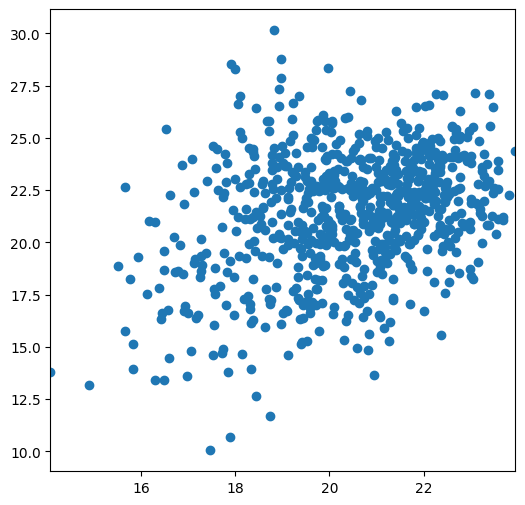

In [40]:
plt.rcParams["figure.figsize"] = (6,6)

def flatten(samples, index):
    return [samples[pid][trial][index] for pid in samples for trial in samples[pid]]
def flatten_sb(samples, index):
    return [samples[pid][trial][index][0] for pid in samples for trial in samples[pid]]
plt.scatter(flatten_sb(samples, "sb_jitter_voiced"), flatten(samples, "praat_jitter"))
#plt.xlim((0, 0.1))

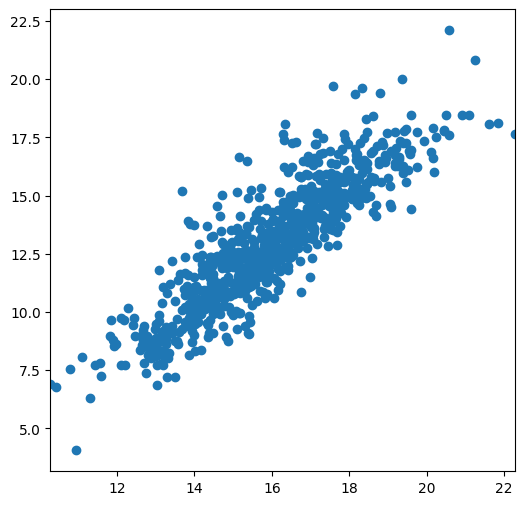

In [41]:
plt.scatter(flatten_sb(samples, "sb_shimmer_voiced"), flatten(samples, "praat_shimmer"))
#plt.ylim((0, 0.4))

(array([  0.,  15., 138., 171., 124.,  82.,  41.,  37.,  25.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
 <BarContainer object of 9 artists>)

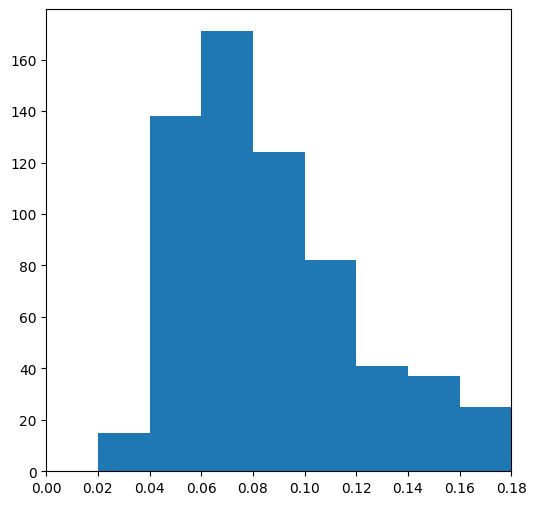

In [42]:
plt.hist(flatten(samples, "sb_time"), bins=np.arange(0, 0.2, 0.02))

(array([  8.,  91., 190., 243., 118.,  64.,  33.,  18.,   8.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
 <BarContainer object of 9 artists>)

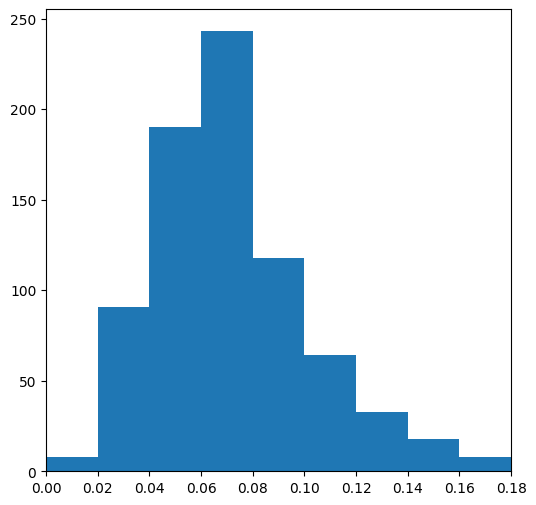

In [43]:
plt.hist(flatten(samples, "praat_time"), bins=np.arange(0, 0.2, 0.02))

(array([ 73., 219., 270., 118.,  59.,  26.,   5.,   4.,   3.,   1.]),
 array([0.04558444, 0.12877829, 0.21197214, 0.29516599, 0.37835984,
        0.46155369, 0.54474754, 0.62794139, 0.71113524, 0.79432909,
        0.87752295]),
 <BarContainer object of 10 artists>)

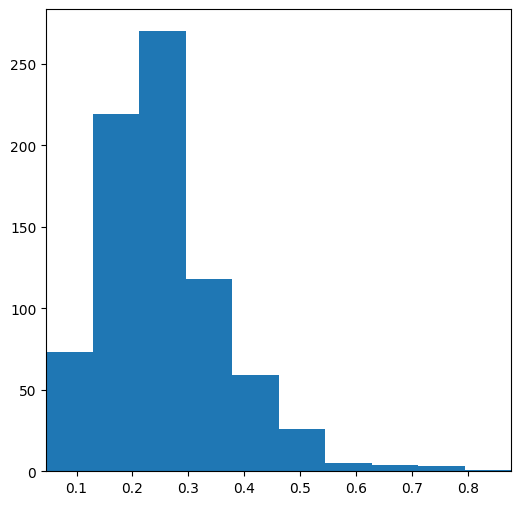

In [44]:
plt.hist(flatten(samples, "opensmile_time"))

## Compute predictiveness

So we will do this for both detection and regression. First separate by PD/non-PD, then correlate with functional score. 

In [45]:
import pandas

batch1 = pandas.read_csv(os.path.join(data_folder, "QPN_Batch1.csv"), index_col=0)
batch2 = pandas.read_csv(os.path.join(data_folder, "QPN_Batch2-demographic.csv"), index_col=0)
qpn = pandas.concat([batch1, batch2]).groupby("pid").last()
qpn.replace({"CTRL": "control", "PD": "patient"}, inplace=True)
len(qpn)

276

In [46]:
xs, ys = [], []
xs2, ys2 = [], []
for pid in qpn.index:
    if qpn.loc[pid].group == "control" and pid in samples:
        for trial in samples[pid]:
            xs.append(samples[pid][trial]["sb_shimmer_voiced"][0])
            ys.append(samples[pid][trial]["sb_hnr_voiced"][0])
    elif qpn.loc[pid].group == "patient" and pid in samples:
        for trial in samples[pid]:
            xs2.append(samples[pid][trial]["sb_shimmer_voiced"][0])
            ys2.append(samples[pid][trial]["sb_hnr_voiced"][0])

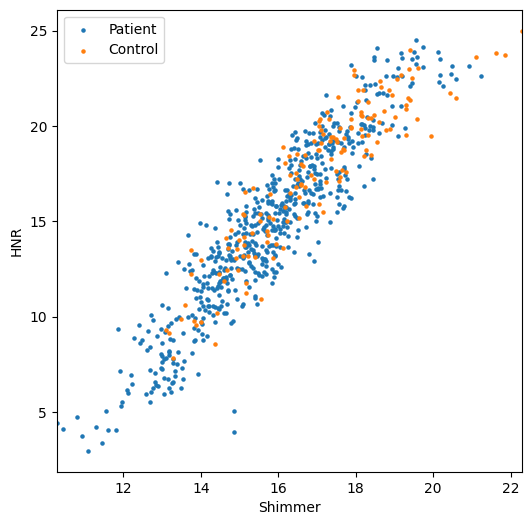

In [47]:
plt.scatter(xs2, ys2, s=5)
plt.scatter(xs, ys, s=5)
#plt.ylim((0, 100))
#plt.xlim((0, 0.3))
plt.xlabel("Shimmer")
plt.ylabel("HNR")
plt.legend(["Patient", "Control"])

## XGBoost

What if we did very basic prediction

In [48]:
# Find which are test samples
test_files = glob.glob(os.path.join(data_folder, "Neuro_split", "test_*", "Batch*", "*_a1.wav"))
test_ids = [os.path.basename(f).split("_")[1] for f in test_files]
print(len(test_ids))

# Find which are valid samples
valid_files = glob.glob(os.path.join(data_folder, "Neuro_split", "valid", "Batch*", "*_a1.wav"))
valid_ids = [os.path.basename(f).split("_")[1] for f in valid_files]
print(len(valid_ids))

32
15


In [51]:
samples["PD00020"]["a1"]["opensmile"].values.shape

(1, 88)

In [88]:
# Collect features
xs, ys = [], []
test_xs, test_ys = [], []
valid_xs, valid_ys = [], []
test_xs_m, test_ys_m, test_xs_f, test_ys_f = [], [], [], []
test_xs_en, test_ys_en, test_xs_fr, test_ys_fr = [], [], [], []
for pid in qpn.index:
    if pid not in samples:
        continue
        
    if qpn.loc[pid].group == "control":
        y = 0
    elif qpn.loc[pid].group == "patient":
        y = 1
    else:
        continue
        
    #row = [qpn.loc[pid].age]
    for t in samples[pid]:
        row = []
    
        for field in ["opensmile"]:
            row.extend(samples[pid][t][field].values[0])
            #row.extend(np.mean([samples[pid][t][field + "_voiced"] for t in samples[pid]], axis=0))
        
        if pid in test_ids:
            test_xs.append(row)
            test_ys.append(y)
    
            if qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M":
                test_xs_m.append(row)
                test_ys_m.append(y)
            if qpn.loc[pid].gender == "F" or qpn.loc[pid].sex == "F":
                test_xs_f.append(row)
                test_ys_f.append(y)
    
            if qpn.loc[pid].Language_used == "English" or qpn.loc[pid].first_language == "EN":
                test_xs_en.append(row)
                test_ys_en.append(y)
            if qpn.loc[pid].Language_used == "French" or qpn.loc[pid].first_language == "FR":
                test_xs_fr.append(row)
                test_ys_fr.append(y)
        elif pid in valid_ids:
            valid_xs.append(row)
            valid_ys.append(y)
        else:
            xs.append(row)
            ys.append(y)

In [89]:
np.array(xs).shape

(623, 88)

In [90]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

avg, avg_m, avg_f, avg_en, avg_fr = 0, 0, 0, 0, 0
for i in range(100):
    xgb = XGBClassifier(scale_pos_weight=0.1, n_estimators=10, learning_rate=0.1, max_depth=5, random_state=i, subsample=0.9)
 
    xgb.fit(xs, ys, eval_set=[(valid_xs, valid_ys)], verbose=0)
    predictions = xgb.predict(test_xs)
    accuracy = accuracy_score(test_ys, predictions)
    avg += accuracy
    

    # Check gender distribution
    predictions_m = xgb.predict(test_xs_m)
    predictions_f = xgb.predict(test_xs_f)
    accuracy_m = accuracy_score(test_ys_m, predictions_m)
    accuracy_f = accuracy_score(test_ys_f, predictions_f)
    avg_m += accuracy_m
    avg_f += accuracy_f
    #print("Accuracy on males: %.2f%%" % (accuracy_m * 100.0))
    #print("Accuracy on females: %.2f%%" % (accuracy_f * 100.0))

    # Check language distribution
    predictions_en = xgb.predict(test_xs_en)
    predictions_fr = xgb.predict(test_xs_fr)
    accuracy_en = accuracy_score(test_ys_en, predictions_en)
    accuracy_fr = accuracy_score(test_ys_fr, predictions_fr)
    avg_en += accuracy_en
    avg_fr += accuracy_fr
    #print("Accuracy on english: %.2f%%" % (accuracy_en * 100.0))
    #print("Accuracy on french: %.2f%%" % (accuracy_fr * 100.0))

print("Accuracy: %.2f%%" % avg)
print("Accuracy on males: %.2f%%" % avg_m)
print("Accuracy on females: %.2f%%" % avg_f)
print("Accuracy on english: %.2f%%" % avg_en)
print("Accuracy on french: %.2f%%" % avg_fr)

Accuracy: 53.62%
Accuracy on males: 48.66%
Accuracy on females: 58.57%
Accuracy on english: 47.55%
Accuracy on french: 62.72%


In [112]:
# Collect features
xs, ys = [], []
test_xs, test_ys = [], []
valid_xs, valid_ys = [], []
test_xs_m, test_ys_m, test_xs_f, test_ys_f = [], [], [], []
test_xs_en, test_ys_en, test_xs_fr, test_ys_fr = [], [], [], []
for pid in qpn.index:
    if pid not in samples:
        continue
        
    if qpn.loc[pid].group == "control":
        y = 0
    elif qpn.loc[pid].group == "patient":
        y = 1
    else:
        continue
        
    for t in samples[pid]:
        row = []

        # Only use mean and std except for f0 which has mean excluded (since it might
        # signal gender and be a confounder)
        for field in ["sb_f0", "sb_jitter", "sb_shimmer", "sb_hnr", "sb_gne"]:
            row.extend(samples[pid][t][field][:2])
        
        if pid in test_ids:
            test_xs.append(row)
            test_ys.append(y)
    
            if qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M":
                test_xs_m.append(row)
                test_ys_m.append(y)
            if qpn.loc[pid].gender == "F" or qpn.loc[pid].sex == "F":
                test_xs_f.append(row)
                test_ys_f.append(y)
    
            if qpn.loc[pid].Language_used == "English" or qpn.loc[pid].first_language == "EN":
                test_xs_en.append(row)
                test_ys_en.append(y)
            if qpn.loc[pid].Language_used == "French" or qpn.loc[pid].first_language == "FR":
                test_xs_fr.append(row)
                test_ys_fr.append(y)
        elif pid in valid_ids:
            valid_xs.append(row)
            valid_ys.append(y)
        else:
            xs.append(row)
            ys.append(y)

In [113]:
np.array(xs).shape

(623, 10)

In [114]:
avg, avg_m, avg_f, avg_en, avg_fr = 0, 0, 0, 0, 0
for i in range(100):
    xgb = XGBClassifier(scale_pos_weight=0.1, n_estimators=5, learning_rate=0.1, max_depth=5, random_state=i, subsample=0.9)
 
    xgb.fit(xs, ys, eval_set=[(valid_xs, valid_ys)], verbose=0)
    predictions = xgb.predict(test_xs)
    accuracy = accuracy_score(test_ys, predictions)
    avg += accuracy
    

    # Check gender distribution
    predictions_m = xgb.predict(test_xs_m)
    predictions_f = xgb.predict(test_xs_f)
    accuracy_m = accuracy_score(test_ys_m, predictions_m)
    accuracy_f = accuracy_score(test_ys_f, predictions_f)
    avg_m += accuracy_m
    avg_f += accuracy_f
    #print("Accuracy on males: %.2f%%" % (accuracy_m * 100.0))
    #print("Accuracy on females: %.2f%%" % (accuracy_f * 100.0))

    # Check language distribution
    predictions_en = xgb.predict(test_xs_en)
    predictions_fr = xgb.predict(test_xs_fr)
    accuracy_en = accuracy_score(test_ys_en, predictions_en)
    accuracy_fr = accuracy_score(test_ys_fr, predictions_fr)
    avg_en += accuracy_en
    avg_fr += accuracy_fr
    #print("Accuracy on english: %.2f%%" % (accuracy_en * 100.0))
    #print("Accuracy on french: %.2f%%" % (accuracy_fr * 100.0))

print("Accuracy: %.2f%%" % avg)
print("Accuracy on males: %.2f%%" % avg_m)
print("Accuracy on females: %.2f%%" % avg_f)
print("Accuracy on english: %.2f%%" % avg_en)
print("Accuracy on french: %.2f%%" % avg_fr)

Accuracy: 54.06%
Accuracy on males: 50.43%
Accuracy on females: 57.70%
Accuracy on english: 50.98%
Accuracy on french: 57.17%
